# Тестирование функций анализа тегов

Этот блокнот демонстрирует использование новых функций:
1. `expand_tags_to_columns()` - раскидывание тегов по столбцам
2. `analyze_tags()` - статистика и корреляционный анализ тегов


In [14]:
# Импорт библиотек
import pandas as pd
import sys
sys.path.insert(0, '/home/alex/tradeML/llm_tags')

from llm_tags import TaggingPipeline
from lmstudio_llm import LMStudioLLM

print("✓ Библиотеки загружены!")


✓ Библиотеки загружены!


## Настройка LLM модели


In [15]:
# Глобальная LLM модель для всех примеров (LM Studio)
LLM = LMStudioLLM(
    api_url="http://192.168.1.26:1234/v1",
    model="qwen3-30b-a3b-instruct-2507",
    temperature=0.7,
    max_tokens=8192,
    timeout=600,
    disable_thinking=True   
)

print("✓ LLM модель настроена!")


✓ LLM модель настроена!


## Шаг 1: Загрузка данных


In [16]:
# Загрузка данных
data_path = "/home/alex/tradeML/llm_tags/demo_sample.csv.gz"

df = pd.read_csv(data_path, compression='gzip')

print(f"Загружено {len(df)} обращений")
print(f"Колонки: {list(df.columns)}")
print(f"\nПервые 5 строк:")
df.head()


Загружено 1000 обращений
Колонки: ['conversation_id', 'speaker', 'date_time', 'text', 'request_id']

Первые 5 строк:


,conversation_id,speaker,date_time,text,request_id
0,c32e822d23da45c2bb85184905226d75,agent,2023-09-07T08:12:21.384618+00:00,(to herself) That was a bit of a challenging c...,demo-0000
1,6d28ea9a0c094c4187f255c0b2cde753,agent,2023-10-05T15:18:32.384615+00:00,"Great, thank you! Now, can you please confirm ...",demo-0001
2,7b987c77f3524fbd817b90e8b9d167c3,agent,2023-11-27T11:03:30.384615+00:00,"Don't worry, Isabella. We'll take care of that...",demo-0002
3,ce9e10ae96b04a35a6bce60ae6f06e81,client,2023-09-15T11:59:01+00:00,"Hi Tressie, thanks for picking up my call agai...",demo-0003
4,dc37cb3f16864b23945ae4e973332c63,agent,2023-11-01T13:41:46.461541+00:00,"You're welcome, Katheryn. Just to recize, I've...",demo-0004


## Шаг 2: Тегирование (холодный старт)


In [17]:
# Создаем pipeline
pipeline = TaggingPipeline(llm=LLM, batch_size=20)

prompt = """
Определи теги для обращений клиентов телеком-оператора.
Теги должны отражать основную проблему обращения.
Ты должна создавать новые теги, если существующие не подходят.
Формируей теги на русском языке.
"""

# Тегирование холодный старт - последовательная обработка (маленькая выборка для теста)
print("Начинаем тегирование холодный старт...")
result_df, tags_dict = pipeline.tag(
    df.sample(100),  # Берем 100 записей для теста
    text_column="text",
    tag_prompt=prompt,
    max_tags=5,
    num_workers=1,
    batch_size=20
)


print(f"\n✓ Тегирование завершено!")
print(f"Всего тегов в словаре: {len(tags_dict)}")
print(f"\nПервые 5 результатов:")
result_df[["request_id", "text", "tags"]].head()


Начинаем тегирование холодный старт...
Всего обращений: 100
Для обработки: 100
Пропущено (уже есть 10+ тегов): 0
Батчей для обработки: 5
[LOG] Последовательная обработка: 5 батчей, начальное количество тегов: 0


Обработка батчей (последовательно):   0%|          | 0/5 [00:00<?, ?batch/s]

[LOG] Запуск батча 1/5 с 0 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 4786 символов
[LMStudio] Отправка запроса на http://192.168.1.26:1234/v1/chat/completions
[LMStudio] Модель: qwen3-30b-a3b-instruct-2507
[LMStudio] Payload keys: ['model', 'messages', 'temperature', 'max_tokens']


Обработка батчей (последовательно):  20%|██        | 1/5 [00:11<00:44, 11.03s/batch, батч=1, тегов=23]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 3505 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "755", "tags": ["время_ремонта"]},
    {"id": "819", "tags": ["запись_на_ремонт"]},
    {"id": "33", "tags": ["модель_телефона", "версия_операционной_системы"]},
    {"id":
[LMStudio] Последние 200 символов: ети": "Предложение проверить работоспособность устройства на другой Wi-Fi или с другим SIM-карте",
    "обновление_тарифа": "Запрос клиента на изменение тарифного плана в сторону более дорогого"
  }
}
[LMStudio] Батч обработан: 20 результатов, 23 новых тегов
[LOG] Батч 1 завершен: добавлено 23 новых тегов (0 -> 23): время_ремонта, переход_на_более_дешевый_тариф, приветствие_пользователя, описание_проблемы, диагностика_проблемы ... (+18 еще)
[LOG] Запуск батча 2/5 с 23 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 6895 символов
[LMStudio] Отправка за

Обработка батчей (последовательно):  40%|████      | 2/5 [00:18<00:27,  9.21s/batch, батч=2, тегов=31]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2286 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "856", "tags": ["закрытие_обращения"]},
    {"id": "408", "tags": ["приветствие_пользователя"]},
    {"id": "183", "tags": ["настройка_доступности"]},
    {"id": "62", "tag
[LMStudio] Последние 200 символов:  выставления счетов или доставки документов",
    "передача_данных_между_устройствами": "Процедура переноса данных (контактов, фото и т. д.) с одного устройства на другое через сервис оператора"
  }
}
[LMStudio] Батч обработан: 20 результатов, 8 новых тегов
[LOG] Батч 2 завершен: добавлено 8 новых тегов (23 -> 31): усиление_сигнала, удаленная_блокировка_устройства, изменение_адреса_получателя, неправильная_информация_о_поддержке, настройка_доступности ... (+3 еще)
[LOG] Запуск батча 3/5 с 31 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 7487 символо

Обработка батчей (последовательно):  60%|██████    | 3/5 [00:25<00:16,  8.17s/batch, батч=3, тегов=37]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1831 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "901", "tags": ["проблемы_с_работой_устройства"]},
    {"id": "466", "tags": ["модель_телефона", "версия_операционной_системы"]},
    {"id": "518", "tags": ["разрядка_батар
[LMStudio] Последние 200 символов: "переход_на_техническую_поддержку": "Передача клиента на техническую поддержку из-за нерешённой проблемы",
    "оплата_услуги_по_телефону": "Запрос способов оплаты услуг через телефонный звонок"
  }
}
[LMStudio] Батч обработан: 20 результатов, 6 новых тегов
[LOG] Батч 3 завершен: добавлено 6 новых тегов (31 -> 37): настройка_уведомлений, проблемы_с_работой_устройства, обратная_связь, переход_на_техническую_поддержку, оплата_услуги_по_телефону ... (+1 еще)
[LOG] Запуск батча 4/5 с 37 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 8038 символов
[LMStud

Обработка батчей (последовательно):  80%|████████  | 4/5 [00:31<00:07,  7.14s/batch, батч=4, тегов=39]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1402 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "345", "tags": ["очистка_кэша_раздела"]},
    {"id": "839", "tags": ["удаленная_блокировка_устройства"]},
    {"id": "939", "tags": ["модель_телефона", "версия_операционной
[LMStudio] Последние 200 символов: блемы_с_тарифом": "Жалобы клиента на неправильное начисление или отсутствие скидок по тарифу",
    "мониторинг_данных": "Запрос клиента на контроль и анализ использования данных в рамках тарифа"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 4 завершен: добавлено 2 новых тегов (37 -> 39): проблемы_с_тарифом, мониторинг_данных
[LOG] Запуск батча 5/5 с 39 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 8801 символов
[LMStudio] Отправка запроса на http://192.168.1.26:1234/v1/chat/completions
[LMStudio] Модель: qwen3-30b-a3b-ins

Обработка батчей (последовательно): 100%|██████████| 5/5 [00:36<00:00,  7.23s/batch, батч=5, тегов=39]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1072 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "870", "tags": ["переход_на_техническую_поддержку"]},
    {"id": "264", "tags": ["приветствие_пользователя"]},
    {"id": "370", "tags": ["мониторинг_данных"]},
    {"id": 
[LMStudio] Последние 200 символов: йка_уведомлений"]},
    {"id": "868", "tags": ["приветствие_пользователя"]},
    {"id": "952", "tags": ["завершение_звонка"]},
    {"id": "508", "tags": ["закрытие_обращения"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 5 завершен: новых тегов нет (39 -> 39)
[LOG] Последовательная обработка завершена: итоговое количество тегов: 39
Обработка завершена. Всего тегов в словаре: 39

✓ Тегирование завершено!
Всего тегов в словаре: 39

Первые 5 результатов:


,request_id,text,tags
755,demo-0755,"Yeah, that sounds good. But can you also me wh...",время_ремонта
819,demo-0819,We usually have same-day appointments availabl...,запись_на_ремонт
33,demo-0033,"Sure, it's a Galaxy S21 Ultra, and it's runnin...","модель_телефона, версия_операционной_системы"
433,demo-0433,"Just to recap, we've tried troubleshooting ste...","диагностика_проблемы, план_ремонта"
365,demo-0365,"Well, I've been thinking about it for a while,...",переход_на_более_дешевый_тариф


In [38]:
# Тегирование горячий старт
result_df, tags_dict = pipeline.tag( 
    df,  # Берем 100 записей для теста
    text_column="text",
    existing_tags=tags_dict,
    tag_prompt=prompt,
    max_tags=5,
    num_workers=5,
    batch_size=20
)

print(f"\n✓ Тегирование завершено!")
print(f"Всего тегов в словаре: {len(tags_dict)}")
print(f"\nПервые 5 результатов:")
result_df[["request_id", "text", "tags"]].head()

Всего обращений: 1000
Для обработки: 1000
Пропущено (уже есть 10+ тегов): 0
Батчей для обработки: 50
[LOG] Параллельная обработка: 50 батчей, max_workers=5, начальное количество тегов: 146
[LOG] Параллельная обработка: запускаем первые 5 батчей
[LOG] Запуск батча 1/50 с 146 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20142 символов
[LMStudio] Отправка запроса на http://192.168.1.26:1234/v1/chat/completions
[LMStudio] Модель: qwen3-30b-a3b-instruct-2507
[LMStudio] Payload keys: ['model', 'messages', 'temperature', 'max_tokens']
[LOG] Запуск батча 2/50 с 146 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 19674 символов
[LMStudio] Отправка запроса на http://192.168.1.26:1234/v1/chat/completions
[LMStudio] Модель: qwen3-30b-a3b-instruct-2507
[LMStudio] Payload keys: ['model', 'messa

Обработка батчей (параллельно с обновлением):   0%|          | 0/50 [00:00<?, ?batch/s]

Обработка батчей (параллельно с обновлением):   2%|▏         | 1/50 [00:07<06:03,  7.41s/batch, батч=1, тегов=146, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1583 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "0", "tags": []},
    {"id": "1", "tags": ["проверка_данных_клиента"]},
    {"id": "2", "tags": ["отмена_сборов_за_данные"]},
    {"id": "3", "tags": ["проблемы_с_сетью", "
[LMStudio] Последние 200 символов: ение функций доступности, таких как экранная читалка или увеличение шрифта",
    "пошаговая_инструкция": "Клиент запрашивает пошаговое руководство или разъяснение действий после выполнения шага"
  }
}
[LMStudio] Батч обработан: 20 результатов, 4 новых тегов
[LOG] Батч 1 завершен: добавлено 146 новых тегов (146 -> 146): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+141 еще)
[LOG] Запуск батча 6/50 с 146 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 19793 символов
[LMStudio] Отправка запроса 

Обработка батчей (параллельно с обновлением):   4%|▍         | 2/50 [00:12<04:59,  6.23s/batch, батч=2, тегов=146, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1298 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "20", "tags": ["модель_телефона", "версия_операционной_системы"]},
    {"id": "21", "tags": ["приветствие_пользователя"]},
    {"id": "22", "tags": ["верификация_идентифика
[LMStudio] Последние 200 символов: 37", "tags": ["продолжение_обслуживания"]},
    {"id": "38", "tags": ["продолжение_обслуживания"]},
    {"id": "39", "tags": ["модель_телефона", "версия_операционной_системы"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 2 завершен: добавлено 146 новых тегов (146 -> 146): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+141 еще)
[LOG] Запуск батча 7/50 с 146 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 19191 символов
[LMStudio] Отправка запроса 

Обработка батчей (параллельно с обновлением):   6%|▌         | 3/50 [00:19<05:11,  6.63s/batch, батч=3, тегов=147, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1745 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "40", "tags": ["прощание"]},
    {"id": "41", "tags": ["прощание"]},
    {"id": "42", "tags": ["благодарность"]},
    {"id": "43", "tags": ["проверка_работы_устройства"]},

[LMStudio] Последние 200 символов: вязанного с вредоносными приложениями или программами",
    "перегрев_телефона": "Жалобы клиента на повышенную температуру телефона, которая может приводить к нестабильной работе или отключению"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 3 завершен: добавлено 147 новых тегов (146 -> 147): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+142 еще)
[LOG] Запуск батча 8/50 с 147 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20671 символов
[LMStudio] Отправка запроса 

Обработка батчей (параллельно с обновлением):   8%|▊         | 4/50 [00:25<04:50,  6.31s/batch, батч=4, тегов=148, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1403 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "60", "tags": ["верификация_идентификатора"]},
    {"id": "61", "tags": ["закрытие_обращения"]},
    {"id": "62", "tags": ["удаленная_блокировка_устройства"]},
    {"id": "
[LMStudio] Последние 200 символов:  поддержки, особенно при ожидании или отсутствии реакции",
    "проверка_состояния_ленты": "Действия по диагностике состояния линзы камеры устройства, включая проверку загрязнений и повреждений"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 4 завершен: добавлено 147 новых тегов (147 -> 148): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+142 еще)
[LOG] Запуск батча 9/50 с 148 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20197 символов
[LMStudio] Отправка запроса 

Обработка батчей (параллельно с обновлением):  10%|█         | 5/50 [00:33<05:14,  6.99s/batch, батч=5, тегов=148, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2047 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "80", "tags": ["неправильное_начисление_услуги"]},
    {"id": "81", "tags": ["обсуждение_тарифного_плана", "анализ_расхода_данных", "рекомендация_оптимизации_тарифа"]},
   
[LMStudio] Последние 200 символов: идание_действий": "Клиент ожидает от оператора следующего шага в решении проблемы",
    "неудачная_настройка": "Попытка клиента выполнить настройку, которая завершилась неудачно, требует помощи"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 5 завершен: добавлено 146 новых тегов (148 -> 148): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+141 еще)
[LOG] Запуск батча 10/50 с 148 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20367 символов
[LMStudio] Отправка запроса

Обработка батчей (параллельно с обновлением):  12%|█▏        | 6/50 [00:40<05:07,  7.00s/batch, батч=6, тегов=149, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1736 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "100", "tags": ["прощание"]},
    {"id": "101", "tags": ["неправильное_начисление_услуги"]},
    {"id": "102", "tags": ["проверка_платежей"]},
    {"id": "103", "tags": ["у
[LMStudio] Последние 200 символов:  "описание_проблемы": "Клиент описывает характер неисправности или нарушения работы устройства",
    "верификация_идентификатора": "Процедура подтверждения личности клиента для доступа к услуге"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 6 завершен: добавлено 147 новых тегов (148 -> 149): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+142 еще)
[LOG] Запуск батча 11/50 с 149 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 19989 символов
[LMStudio] Отправка запроса

Обработка батчей (параллельно с обновлением):  14%|█▍        | 7/50 [00:46<04:41,  6.54s/batch, батч=7, тегов=150, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1324 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "120", "tags": ["приветствие_пользователя"]},
    {"id": "121", "tags": []},
    {"id": "122", "tags": ["не_решена_проблема"]},
    {"id": "123", "tags": ["прощание"]},
   
[LMStudio] Последние 200 символов: вает возможность диагностики и ремонта устройства в центре обслуживания",
    "анализ_использования_данных": "Клиент жалуется на неожиданно высокое потребление трафика, требует выявления причин"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 7 завершен: добавлено 147 новых тегов (149 -> 150): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+142 еще)
[LOG] Запуск батча 12/50 с 150 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20488 символов
[LMStudio] Отправка запроса

Обработка батчей (параллельно с обновлением):  16%|█▌        | 8/50 [00:54<04:55,  7.04s/batch, батч=8, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1728 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "140", "tags": ["ожидание_помощи"]},
    {"id": "141", "tags": ["включение_безопасного_режима"]},
    {"id": "142", "tags": ["верификация_идентификатора"]},
    {"id": "143
[LMStudio] Последние 200 символов: ии_о_тарифе": "Клиент запрашивает информацию о стоимости или условиях тарифного плана",
    "рекомендация_оптимизации_тарифа": "Предложение клиенту сменить тариф для снижения расходов на данные"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 8 завершен: добавлено 148 новых тегов (150 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+143 еще)
[LOG] Запуск батча 13/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20031 символов
[LMStudio] Отправка запроса

Обработка батчей (параллельно с обновлением):  18%|█▊        | 9/50 [01:04<05:23,  7.88s/batch, батч=9, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2350 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {
      "id": "160",
      "tags": ["проверка_режима_сети", "предложение_решений"]
    },
    {
      "id": "161",
      "tags": ["прощание"]
    },
    {
      "id": "162",
     
[LMStudio] Последние 200 символов: жностей": "Клиент интересуется альтернативными вариантами решения проблемы или функционалом",
    "не_решена_проблема": "Клиент сообщает, что предложенные решения не помогают устранить проблему"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 9 завершен: добавлено 148 новых тегов (151 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+143 еще)
[LOG] Запуск батча 14/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20702 символов
[LMStudio] Отправка запроса

Обработка батчей (параллельно с обновлением):  20%|██        | 10/50 [01:13<05:34,  8.35s/batch, батч=10, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2263 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "180", "tags": ["тестирование_соединения"]},
    {"id": "181", "tags": ["проблемы_с_приложениями", "автоматическое_отключение_телефона", "неожиданное_поведение_приложения"]
[LMStudio] Последние 200 символов: лнения технической поддержки, особенно при ожидании или отсутствии реакции",
    "пошаговая_инструкция": "Клиент запрашивает пошаговое руководство или разъяснение действий после выполнения шага"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 10 завершен: добавлено 148 новых тегов (151 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+143 еще)
[LOG] Запуск батча 15/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20373 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  22%|██▏       | 11/50 [01:20<05:09,  7.94s/batch, батч=11, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1674 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "200", "tags": ["обновление_тарифа"]},
    {"id": "201", "tags": []},
    {"id": "202", "tags": ["верификация_идентификатора"]},
    {"id": "203", "tags": ["закрытие_обраще
[LMStudio] Последние 200 символов: арифа": "Оператор предлагает сменить тариф для снижения расходов на данные",
    "анализ_расхода_данных": "Клиент жалуется на быстрое расходование трафика, требуется анализ использования данных"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 11 завершен: добавлено 149 новых тегов (151 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+144 еще)
[LOG] Запуск батча 16/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20083 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  24%|██▍       | 12/50 [01:29<05:13,  8.24s/batch, батч=12, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1976 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "220", "tags": []},
    {"id": "221", "tags": ["проверка_обновлений"]},
    {"id": "222", "tags": ["уточнение_данных"]},
    {"id": "223", "tags": ["проблемы_с_голосовой_по
[LMStudio] Последние 200 символов: ли неверной информации, полученной от предыдущего сотрудника поддержки",
    "обсуждение_тарифного_плана": "Общение с клиентом по подбору подходящего тарифа с учётом его потреблений и поведения"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 12 завершен: добавлено 150 новых тегов (151 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+145 еще)
[LOG] Запуск батча 17/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20525 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  26%|██▌       | 13/50 [01:36<04:44,  7.68s/batch, батч=13, тегов=151, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1139 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "240", "tags": ["диагностика_проблемы"]},
    {"id": "241", "tags": ["прощание"]},
    {"id": "242", "tags": ["верификация_идентификатора"]},
    {"id": "243", "tags": []},
[LMStudio] Последние 200 символов: е_проблемы"]},
    {"id": "257", "tags": ["проверка_работы_устройства"]},
    {"id": "258", "tags": []},
    {"id": "259", "tags": ["диагностика_камеры", "проблемы_с_камерой"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 13 завершен: добавлено 151 новых тегов (151 -> 151): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+146 еще)
[LOG] Запуск батча 18/50 с 151 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20234 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  28%|██▊       | 14/50 [01:46<05:00,  8.36s/batch, батч=14, тегов=152, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2102 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "260", "tags": ["инструкции_по_настройке_функции"]},
    {"id": "261", "tags": ["обсуждение_тарифного_плана", "переход_на_другой_тариф", "рекомендация_тарифа"]},
    {"id":
[LMStudio] Последние 200 символов: ючение, зависания, лаги, несмотря на исправную работу системы",
    "анализ_использования_данных": "Проверка расхода трафика с целью выявить причины превышения лимита или неожиданного поведения"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 14 завершен: добавлено 152 новых тегов (151 -> 152): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+147 еще)
[LOG] Запуск батча 19/50 с 152 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21163 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  30%|███       | 15/50 [01:55<05:00,  8.58s/batch, батч=15, тегов=154, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2035 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "280", "tags": ["прощание"]},
    {"id": "281", "tags": ["проблемы_с_сетью", "время_ремонта", "предложение_дополнительной_услуги"]},
    {"id": "282", "tags": ["верификация
[LMStudio] Последние 200 символов: или отсутствия реакции со стороны службы поддержки",
    "анализ_проблемы_с_приложениями": "Оператор проводит проверку и выявление причин неработоспособности приложений после обновления системы"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 15 завершен: добавлено 153 новых тегов (152 -> 154): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+148 еще)
[LOG] Запуск батча 20/50 с 154 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21452 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  32%|███▏      | 16/50 [02:04<05:00,  8.83s/batch, батч=16, тегов=154, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2014 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "300", "tags": ["прощание"]},
    {"id": "301", "tags": ["неопределенная_поломка", "поиск_решения"]},
    {"id": "302", "tags": ["проблемы_с_подключением", "тестирование_со
[LMStudio] Последние 200 символов: справности или проблем с сетью",
    "недовольство_процессом": "Клиент выражает раздражение или недовольство ходом выполнения технической поддержки, особенно при ожидании или отсутствии реакции"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 16 завершен: добавлено 151 новых тегов (154 -> 154): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+146 еще)
[LOG] Запуск батча 21/50 с 154 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21455 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  34%|███▍      | 17/50 [02:12<04:44,  8.62s/batch, батч=17, тегов=155, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1669 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "320", "tags": ["анализ_использования_данных"]},
    {"id": "321", "tags": []},
    {"id": "322", "tags": ["замена_устройства", "приостановка_услуги"]},
    {"id": "323", "
[LMStudio] Последние 200 символов: арифа в зависимости от его потребностей и поведения",
    "неправильная_информация_о_поддержке": "Клиент сообщает, что полученные ранее инструкции или разъяснения были неверными или непонятными"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 17 завершен: добавлено 152 новых тегов (154 -> 155): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+147 еще)
[LOG] Запуск батча 22/50 с 155 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20933 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  36%|███▌      | 18/50 [02:20<04:28,  8.41s/batch, батч=18, тегов=157, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1621 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "340", "tags": ["прощание"]},
    {"id": "341", "tags": ["мониторинг_данных", "проверка_проблемы"]},
    {"id": "342", "tags": ["перезагрузка_устройства"]},
    {"id": "343
[LMStudio] Последние 200 символов: Процедура активации или настройки SIM-карты после замены или установки",
    "вопрос_о_гарантии": "Запрос клиента о возможности восстановления функционала устройства в рамках гарантийного срока"
  }
}
[LMStudio] Батч обработан: 20 результатов, 4 новых тегов
[LOG] Батч 18 завершен: добавлено 153 новых тегов (155 -> 157): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+148 еще)
[LOG] Запуск батча 23/50 с 157 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21564 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  38%|███▊      | 19/50 [02:28<04:19,  8.38s/batch, батч=19, тегов=157, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1638 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "360", "tags": ["проблемы_с_камерой", "диагностика_камеры"]},
    {"id": "361", "tags": []},
    {"id": "362", "tags": []},
    {"id": "363", "tags": ["приветствие_пользова
[LMStudio] Последние 200 символов: рки и выявления неисправностей, связанных с работой камеры устройства",
    "удаленная_диагностика_устройства": "Оператор запрашивает разрешение на удалённый доступ к устройству для диагностики"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 19 завершен: добавлено 152 новых тегов (157 -> 157): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+147 еще)
[LOG] Запуск батча 24/50 с 157 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21139 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  40%|████      | 20/50 [02:37<04:16,  8.54s/batch, батч=20, тегов=157, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1738 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "380", "tags": ["рекомендация_приложения"]},
    {"id": "381", "tags": ["настройка_сканера_отпечатков"]},
    {"id": "382", "tags": ["мониторинг_данных", "проверка_работы_у
[LMStudio] Последние 200 символов: иложениями"]},
    {"id": "398", "tags": ["прощание", "завершение_звонка"]},
    {"id": "399", "tags": ["продолжение_обслуживания", "уточнение_данных", "пошаговая_инструкция"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 20 завершен: добавлено 154 новых тегов (157 -> 157): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+149 еще)
[LOG] Запуск батча 25/50 с 157 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21123 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  42%|████▏     | 21/50 [02:47<04:21,  9.01s/batch, батч=21, тегов=157, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2168 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "400", "tags": ["добавление_устройства"]},
    {"id": "401", "tags": ["настройка_международного_роуминга", "обсуждение_тарифного_плана"]},
    {"id": "402", "tags": ["перех
[LMStudio] Последние 200 символов: ия при использовании устройства, не связанные с конкретным приложением",
    "проверка_работы_устройства": "Подтверждение корректной работы устройства после выполненных действий или диагностики"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 21 завершен: добавлено 154 новых тегов (157 -> 157): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+149 еще)
[LOG] Запуск батча 26/50 с 157 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20695 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  44%|████▍     | 22/50 [02:56<04:10,  8.95s/batch, батч=22, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1773 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "420", "tags": ["модель_телефона"]},
    {"id": "421", "tags": ["анализ_проблемы_с_приложениями", "предложение_решений"]},
    {"id": "422", "tags": ["верификация_идентифик
[LMStudio] Последние 200 символов: нения потребления",
    "анализ_изменений_в_аккаунте": "Клиент указывает на недавние изменения в аккаунте, влияющие на сервис",
    "настройка_wifi": "Помощь клиенту по подключению к Wi-Fi сети"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 22 завершен: добавлено 156 новых тегов (157 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+151 еще)
[LOG] Запуск батча 27/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20346 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  46%|████▌     | 23/50 [03:03<03:45,  8.37s/batch, батч=23, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1160 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "440", "tags": ["оплата_услуги_по_телефону"]},
    {"id": "441", "tags": ["прощание"]},
    {"id": "442", "tags": ["закрытие_обращения"]},
    {"id": "443", "tags": ["ожида
[LMStudio] Последние 200 символов: gs": ["проверка_работы_устройства"]},
    {"id": "457", "tags": ["начало_звонка"]},
    {"id": "458", "tags": ["настройка_почты"]},
    {"id": "459", "tags": ["благодарность"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 23 завершен: добавлено 157 новых тегов (158 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+152 еще)
[LOG] Запуск батча 28/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21060 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  48%|████▊     | 24/50 [03:11<03:32,  8.17s/batch, батч=24, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1513 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "460", "tags": ["верификация_идентификатора"]},
    {"id": "461", "tags": ["настройка_функции"]},
    {"id": "462", "tags": ["диагностика_проблемы"]},
    {"id": "463", "ta
[LMStudio] Последние 200 символов: са",
    "обсуждение_возможностей": "Клиент интересуется альтернативными вариантами решения проблемы или функционалом",
    "благодарность": "Клиент выражает признательность за оказанную помощь"
  }
}
[LMStudio] Батч обработан: 20 результатов, 4 новых тегов
[LOG] Батч 24 завершен: добавлено 157 новых тегов (158 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+152 еще)
[LOG] Запуск батча 29/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21455 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  50%|█████     | 25/50 [03:17<03:09,  7.58s/batch, батч=25, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1083 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "480", "tags": ["начало_звонка"]},
    {"id": "481", "tags": ["верификация_идентификатора"]},
    {"id": "482", "tags": ["прощание"]},
    {"id": "483", "tags": ["продолжен
[LMStudio] Последние 200 символов: id": "496", "tags": ["обсуждение_тарифного_плана"]},
    {"id": "497", "tags": []},
    {"id": "498", "tags": ["начало_звонка"]},
    {"id": "499", "tags": ["не_путешествует"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 25 завершен: добавлено 157 новых тегов (158 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+152 еще)
[LOG] Запуск батча 30/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20927 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  52%|█████▏    | 26/50 [03:26<03:11,  7.98s/batch, батч=26, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1747 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "500", "tags": ["благодарность"]},
    {"id": "501", "tags": ["настройка_сканера_отпечатков", "проблемы_с_приложениями"]},
    {"id": "502", "tags": ["проверка_данных_клиен
[LMStudio] Последние 200 символов: ходом обслуживания, особенно ожиданием или отсутствием реакции",
    "проверка_данных_клиента": "Запрос или подтверждение персональной информации клиента (номер телефона, PIN) для идентификации"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 26 завершен: добавлено 157 новых тегов (158 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+152 еще)
[LOG] Запуск батча 31/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21829 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  54%|█████▍    | 27/50 [03:33<02:55,  7.63s/batch, батч=27, тегов=158, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1131 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "520", "tags": ["верификация_идентификатора"]},
    {"id": "521", "tags": ["подтверждение_действия"]},
    {"id": "522", "tags": ["не_решена_проблема"]},
    {"id": "523", 
[LMStudio] Последние 200 символов: tags": ["не_решена_проблема"]},
    {"id": "537", "tags": ["прощание"]},
    {"id": "538", "tags": ["верификация_идентификатора"]},
    {"id": "539", "tags": ["благодарность"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 27 завершен: добавлено 158 новых тегов (158 -> 158): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+153 еще)
[LOG] Запуск батча 32/50 с 158 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21552 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  56%|█████▌    | 28/50 [03:41<02:48,  7.65s/batch, батч=28, тегов=159, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1394 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "540", "tags": ["уточнение_действий"]},
    {"id": "541", "tags": ["вопрос_о_гарантии"]},
    {"id": "542", "tags": ["просьба_об_отмене_платежа", "подтверждение_действия"]}
[LMStudio] Последние 200 символов: устройства, включая процент здоровья батареи",
    "проверка_режима_сети": "Действия по проверке режима сетевого подключения (например, отсутствие включенности режима полета или настройки сети)"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 28 завершен: добавлено 159 новых тегов (158 -> 159): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+154 еще)
[LOG] Запуск батча 33/50 с 159 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 20931 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  58%|█████▊    | 29/50 [03:49<02:42,  7.73s/batch, батч=29, тегов=159, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1530 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "560", "tags": ["поиск_решения"]},
    {"id": "561", "tags": ["прощание"]},
    {"id": "562", "tags": ["удаленная_диагностика_устройства"]},
    {"id": "563", "tags": ["зак
[LMStudio] Последние 200 символов:  в аккаунте, которые могут влиять на работу сервиса",
    "проверка_данных_клиента": "Оператор запрашивает и проверяет персональные данные клиента для идентификации или подтверждения информации"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 29 завершен: добавлено 158 новых тегов (159 -> 159): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+153 еще)
[LOG] Запуск батча 34/50 с 159 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22285 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  60%|██████    | 30/50 [03:57<02:38,  7.94s/batch, батч=30, тегов=159, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1647 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "580", "tags": []},
    {"id": "581", "tags": ["проблемы_с_вызовами", "переход_на_техническую_поддержку"]},
    {"id": "582", "tags": ["подтверждение_действия"]},
    {"id"
[LMStudio] Последние 200 символов: рую разрядку или нестабильную работу аккумулятора",
    "разрядка_батареи_при_использовании_приложений": "Проблемы с быстрой разрядкой батареи при активном использовании определенных приложений"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 30 завершен: добавлено 158 новых тегов (159 -> 159): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+153 еще)
[LOG] Запуск батча 35/50 с 159 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21424 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  62%|██████▏   | 31/50 [04:08<02:46,  8.77s/batch, батч=31, тегов=160, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2106 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "600", "tags": ["благодарность"]},
    {"id": "601", "tags": ["настройка_международного_роуминга", "проблемы_с_роумингом"]},
    {"id": "602", "tags": ["не_решена_проблема"
[LMStudio] Последние 200 символов: : "Клиент пытался выполнить настройку, но она завершилась ошибкой или не привела к желаемому результату",
    "благодарность": "Выражение признательности клиентом за оказанную помощь оператором"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 31 завершен: добавлено 159 новых тегов (159 -> 160): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+154 еще)
[LOG] Запуск батча 36/50 с 160 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21498 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  64%|██████▍   | 32/50 [04:18<02:47,  9.29s/batch, батч=32, тегов=161, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2046 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "620", "tags": ["перегрев_телефона", "автоматическое_отключение_телефона"]},
    {"id": "621", "tags": ["не_решена_проблема", "недовольство_процессом", "жалоба_на_службу"]}
[LMStudio] Последние 200 символов: пользовании антивирусного ПО",
    "диагностика_аппаратной_неисправности": "Тег для выявления неисправностей, связанных с внутренними компонентами устройства, при отсутствии программных решений"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 32 завершен: добавлено 159 новых тегов (160 -> 161): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+154 еще)
[LOG] Запуск батча 37/50 с 161 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22032 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  66%|██████▌   | 33/50 [04:27<02:35,  9.15s/batch, батч=33, тегов=166, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1767 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "640", "tags": ["подключение_к_wifi"]},
    {"id": "641", "tags": ["номер_телефона"]},
    {"id": "642", "tags": ["прощание"]},
    {"id": "643", "tags": ["уточнение_функци
[LMStudio] Последние 200 символов: лиент выражает намерение уйти от текущего оператора из-за плохого качества сервиса",
    "просьба_о_инструкции": "Клиент просит подробные шаги или демонстрацию использования функции или сервиса"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 33 завершен: добавлено 164 новых тегов (161 -> 166): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+159 еще)
[LOG] Запуск батча 38/50 с 166 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21693 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  68%|██████▊   | 34/50 [04:39<02:41, 10.10s/batch, батч=34, тегов=168, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2650 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "660", "tags": ["проблемы_с_сетью", "предложение_замены_устройства", "объяснение_причины_проблемы"]},
    {"id": "661", "tags": ["не_решена_проблема", "рекомендация_действи
[LMStudio] Последние 200 символов: аздражение по поводу длительного ожидания или неэффективности процесса поддержки",
    "возврат_к_клиенту": "Сообщение, что клиент будет перенаправлен обратно после общения с другим сотрудником"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 34 завершен: добавлено 161 новых тегов (166 -> 168): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+156 еще)
[LOG] Запуск батча 39/50 с 168 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21634 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  70%|███████   | 35/50 [04:50<02:32, 10.16s/batch, батч=35, тегов=169, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2117 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "680", "tags": ["проблемы_с_устройством", "неопределенная_поломка"]},
    {"id": "681", "tags": ["опрос_о_использовании_приложений", "описание_проблемы"]},
    {"id": "682"
[LMStudio] Последние 200 символов: клиенту отключить международный роуминг из-за ненужности или ошибочного включения",
    "неудачная_настройка": "Попытка клиента выполнить настройку, которая завершилась неудачно, требует помощи"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 35 завершен: добавлено 160 новых тегов (168 -> 169): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+155 еще)
[LOG] Запуск батча 40/50 с 169 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22179 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  72%|███████▏  | 36/50 [04:57<02:09,  9.28s/batch, батч=36, тегов=169, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1168 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "700", "tags": ["не_путешествует"]},
    {"id": "701", "tags": ["ошибка_начисления_скидки"]},
    {"id": "702", "tags": ["прощание"]},
    {"id": "703", "tags": ["прощание"
[LMStudio] Последние 200 символов: id": "716", "tags": ["удаленная_помощь"]},
    {"id": "717", "tags": ["прощание"]},
    {"id": "718", "tags": ["начало_звонка"]},
    {"id": "719", "tags": ["модель_телефона"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 36 завершен: добавлено 160 новых тегов (169 -> 169): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+155 еще)
[LOG] Запуск батча 41/50 с 169 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22666 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  74%|███████▍  | 37/50 [05:05<01:56,  8.96s/batch, батч=37, тегов=169, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1503 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "720", "tags": ["не_решена_проблема"]},
    {"id": "721", "tags": ["настройка_международного_роуминга"]},
    {"id": "722", "tags": ["переход_на_техническую_поддержку"]},
 
[LMStudio] Последние 200 символов: ниями": "Клиент жалуется на нестабильную работу приложений, требуются анализ и рекомендации",
    "не_решена_проблема": "Клиент сообщает, что предложенные решения не помогают устранить проблему"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 37 завершен: добавлено 161 новых тегов (169 -> 169): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+156 еще)
[LOG] Запуск батча 42/50 с 169 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 21721 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  76%|███████▌  | 38/50 [05:15<01:50,  9.21s/batch, батч=38, тегов=169, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1948 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "740", "tags": ["закрытие_обращения", "благодарность"]},
    {"id": "741", "tags": ["проверка_данных_клиента", "уточнение_данных"]},
    {"id": "742", "tags": ["обратная_св
[LMStudio] Последние 200 символов: ыполнения действия или ответа от оператора",
    "неправильная_информация_о_поддержке": "Клиент сообщает о противоречивой или неверной информации, полученной от предыдущего сотрудника поддержки"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 38 завершен: добавлено 166 новых тегов (169 -> 169): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+161 еще)
[LOG] Запуск батча 43/50 с 169 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22187 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  78%|███████▊  | 39/50 [05:24<01:42,  9.27s/batch, батч=39, тегов=169, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1883 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "760", "tags": ["проверка_данных_клиента", "модель_телефона"]},
    {"id": "761", "tags": ["ожидание_действий"]},
    {"id": "762", "tags": ["диагностика_камеры", "проверка
[LMStudio] Последние 200 символов:  или действие по перезагрузке телефона для устранения неисправности",
    "удаленная_блокировка_устройства": "Процедура удаленного блокирования устройства по запросу клиента при утере или краже"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 39 завершен: добавлено 168 новых тегов (169 -> 169): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+163 еще)
[LOG] Запуск батча 44/50 с 169 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22656 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  80%|████████  | 40/50 [05:32<01:27,  8.78s/batch, батч=40, тегов=171, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1449 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "780", "tags": ["проблемы_с_камерой", "диагностика_камеры"]},
    {"id": "781", "tags": ["закрытие_обращения"]},
    {"id": "782", "tags": ["подтверждение_действия"]},
    
[LMStudio] Последние 200 символов: новить программное обеспечение устройства или услуги",
    "проблемы_с_софтом": "Жалобы на нестабильную работу или сбои в работе программного обеспечения, включая приложения и системные функции"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 40 завершен: добавлено 171 новых тегов (169 -> 171): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+166 еще)
[LOG] Запуск батча 45/50 с 171 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22766 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  82%|████████▏ | 41/50 [05:42<01:22,  9.15s/batch, батч=41, тегов=171, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1863 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "800", "tags": ["благодарность"]},
    {"id": "801", "tags": ["закрытие_обращения"]},
    {"id": "802", "tags": ["прощание", "продолжение_обслуживания"]},
    {"id": "803",
[LMStudio] Последние 200 символов: несмотря на исправную работу системы",
    "проблемы_с_рекламой": "Появляются нежелательные рекламные всплывания и объявления при использовании устройства, не связанные с конкретным приложением"
  }
}
[LMStudio] Батч обработан: 20 результатов, 2 новых тегов
[LOG] Батч 41 завершен: добавлено 169 новых тегов (171 -> 171): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+164 еще)
[LOG] Запуск батча 46/50 с 171 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22726 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  84%|████████▍ | 42/50 [05:49<01:07,  8.48s/batch, батч=42, тегов=171, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1113 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "820", "tags": ["благодарность"]},
    {"id": "821", "tags": ["прощание"]},
    {"id": "822", "tags": ["прощание"]},
    {"id": "823", "tags": ["закрытие_обращения"]},
    
[LMStudio] Последние 200 символов:  "837", "tags": ["закрытие_обращения"]},
    {"id": "838", "tags": ["подтверждение_действия"]},
    {"id": "839", "tags": ["потеря_устройства", "рекомендация_отмены_роуминга"]}
  ],
  "new_tags": {}
}
[LMStudio] Батч обработан: 20 результатов, 0 новых тегов
[LOG] Батч 42 завершен: добавлено 169 новых тегов (171 -> 171): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+164 еще)
[LOG] Запуск батча 47/50 с 171 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22728 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  86%|████████▌ | 43/50 [05:59<01:02,  9.00s/batch, батч=43, тегов=172, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2104 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "840", "tags": ["не_решена_проблема"]},
    {"id": "841", "tags": ["прощание"]},
    {"id": "842", "tags": ["замена_устройства", "передача_данных_между_устройствами", "наст
[LMStudio] Последние 200 символов:  фото и т. д.) с одного устройства на другое через сервис оператора",
    "настройка_новой_функции": "Клиент запрашивает помощь по настройке недавно добавленной функции в устройстве или сервисе"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 43 завершен: добавлено 170 новых тегов (171 -> 172): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+165 еще)
[LOG] Запуск батча 48/50 с 172 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22937 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  88%|████████▊ | 44/50 [06:08<00:53,  8.91s/batch, батч=44, тегов=175, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1570 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "860", "tags": ["прощание"]},
    {"id": "861", "tags": ["не_понял_объяснение"]},
    {"id": "862", "tags": ["подтверждение_действия"]},
    {"id": "863", "tags": ["не_попр
[LMStudio] Последние 200 символов: струкций оператора, требует уточнения",
    "желание_перехода_на_другой_оператор": "Клиент прямо или косвенно указывает на намерение сменить телеком-оператора из-за неудовлетворённости сервисом"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 44 завершен: добавлено 172 новых тегов (172 -> 175): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+167 еще)
[LOG] Запуск батча 49/50 с 175 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 22587 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  90%|█████████ | 45/50 [06:17<00:45,  9.09s/batch, батч=45, тегов=175, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1876 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "880", "tags": ["верификация_идентификатора"]},
    {"id": "881", "tags": ["приветствие_пользователя"]},
    {"id": "882", "tags": ["приветствие_пользователя"]},
    {"id":
[LMStudio] Последние 200 символов: "Попытка клиента выполнить настройку, которая завершилась неудачно, требует помощи",
    "просьба_о_инструкции": "Клиент просит подробные шаги или демонстрацию использования функции или сервиса"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 45 завершен: добавлено 171 новых тегов (175 -> 175): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+166 еще)
[LOG] Запуск батча 50/50 с 175 тегами в словаре
[LMStudio] Обработка батча из 20 обращений
[LMStudio] Отправка запроса к модели qwen3-30b-a3b-instruct-2507
[LMStudio] Длина промпта: 23437 символов
[LMStudio] Отправка запрос

Обработка батчей (параллельно с обновлением):  92%|█████████▏| 46/50 [06:28<00:37,  9.46s/batch, батч=46, тегов=176, активных=4]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2021 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "900", "tags": ["проблемы_с_сетью", "устранение_проблемы_с_сигналом"]},
    {"id": "901", "tags": ["недовольство_услугой", "жалоба_на_службу"]},
    {"id": "902", "tags": [
[LMStudio] Последние 200 символов: ройство в базе данных оператора или при помощи идентификаторов (IMEI)",
    "удаленная_диагностика_устройства": "Оператор запрашивает разрешение на удалённый доступ к устройству для диагностики"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 46 завершен: добавлено 172 новых тегов (175 -> 176): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+167 еще)


Обработка батчей (параллельно с обновлением):  94%|█████████▍| 47/50 [06:38<00:28,  9.63s/batch, батч=47, тегов=177, активных=3]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1874 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "920", "tags": ["номер_телефона"]},
    {"id": "921", "tags": ["ошибка_при_обновлении", "неудачная_настройка"]},
    {"id": "922", "tags": ["проблемы_с_подключением", "проб
[LMStudio] Последние 200 символов: нии ближайшего магазина или авторизованного ритейлера оператора",
    "версия_операционной_системы": "Указание версии операционной системы, установленной на устройстве (новый тег для уточнения)"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 47 завершен: добавлено 172 новых тегов (176 -> 177): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+167 еще)


Обработка батчей (параллельно с обновлением):  96%|█████████▌| 48/50 [06:47<00:18,  9.47s/batch, батч=48, тегов=177, активных=2]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1701 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "940", "tags": ["настройка_функции", "пошаговая_инструкция"]},
    {"id": "941", "tags": ["поиск_магазина"]},
    {"id": "942", "tags": ["предложение_компенсации", "обсужде
[LMStudio] Последние 200 символов: ю за неудобства, вызванные техническими сбоями или ошибочными начислениями",
    "анализ_расхода_данных": "Клиент жалуется на быстрое расходование трафика, требуется анализ использования данных"
  }
}
[LMStudio] Батч обработан: 20 результатов, 3 новых тегов
[LOG] Батч 48 завершен: добавлено 172 новых тегов (177 -> 177): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+167 еще)


Обработка батчей (параллельно с обновлением):  98%|█████████▊| 49/50 [06:56<00:09,  9.55s/batch, батч=49, тегов=177, активных=1]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 1931 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "960", "tags": ["прощание"]},
    {"id": "961", "tags": ["обсуждение_тарифного_плана", "рекомендация_тарифа", "предложение_компенсации"]},
    {"id": "962", "tags": ["закры
[LMStudio] Последние 200 символов: говая_инструкция": "Клиент запрашивает пошаговое руководство или разъяснение действий после выполнения шага",
    "подтверждение_действия": "Подтверждение выполнения действия по запросу клиента"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 49 завершен: добавлено 175 новых тегов (177 -> 177): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+170 еще)


Обработка батчей (параллельно с обновлением): 100%|██████████| 50/50 [07:09<00:00,  8.58s/batch, батч=50, тегов=177, активных=0]

[LMStudio] Запрос успешен
[LMStudio] Получен ответ длиной 2498 символов
[LMStudio] Первые 200 символов: {
  "results": [
    {"id": "980", "tags": ["анализ_расхода_данных", "рекомендация_оптимизации_тарифа", "мониторинг_данных"]},
    {"id": "981", "tags": []},
    {"id": "982", "tags": ["закрытие_обращ
[LMStudio] Последние 200 символов: хочет использовать тариф при поездке за границу, требуется настройка роуминга",
    "анализ_использования_данных": "Проведение проверки расхода данных с целью выявления причин превышения лимита"
  }
}
[LMStudio] Батч обработан: 20 результатов, 5 новых тегов
[LOG] Батч 50 завершен: добавлено 175 новых тегов (177 -> 177): время_ремонта, запись_на_ремонт, модель_телефона, версия_операционной_системы, диагностика_проблемы ... (+170 еще)
[LOG] Параллельная обработка завершена: итоговое количество тегов: 177
Обработка завершена. Всего тегов в словаре: 177

✓ Тегирование завершено!
Всего тегов в словаре: 177

Первые 5 результатов:


,request_id,text,tags
0,demo-0000,(to herself) That was a bit of a challenging c...,
1,demo-0001,"Great, thank you! Now, can you please confirm ...",проверка_данных_клиента
2,demo-0002,"Don't worry, Isabella. We'll take care of that...",отмена_сборов_за_данные
3,demo-0003,"Hi Tressie, thanks for picking up my call agai...","проблемы_с_сетью, проблемы_с_подключением"
4,demo-0004,"You're welcome, Katheryn. Just to recize, I've...","обновление_тарифа, изменение_адреса_получателя"


## Шаг 3: Раскидывание тегов по столбцам


In [27]:
# Раскидываем теги по столбцам
print("Раскидываем теги по столбцам...")
expanded_df = pipeline.expand_tags_to_columns(result_df, tags_column="tags")

tag_columns = [col for col in expanded_df.columns if col.startswith("tag_")]
print(f"\n✓ Создано {len(tag_columns)} столбцов с тегами")
print(f"Примеры столбцов: {tag_columns[:10]}")


Раскидываем теги по столбцам...
Создано 158 столбцов для тегов

✓ Создано 158 столбцов с тегами
Примеры столбцов: ['tag_потеря_устройства', 'tag_приветствие_пользователя', 'tag_изменение_адреса_получателя', 'tag_проверка_подключения_к_телефону', 'tag_поиск_утерянного_устройства', 'tag_инструкции_по_настройке_функции', 'tag_автоматическое_отключение_телефона', 'tag_усиление_сигнала', 'tag_ожидание_помощи', 'tag_рекомендация_просмотра_приложений']


/home/alex/tradeML/llm_tags/llm_tags.py:740: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[column_name] = result_df[tags_column].apply(
/home/alex/tradeML/llm_tags/llm_tags.py:740: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[column_name] = result_df[tags_column].apply(
/home/alex/tradeML/llm_tags/llm_tags.py:740: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

In [28]:
expanded_df[tag_columns].mean().sort_values(ascending=False)

tag_закрытие_обращения            0.089
tag_верификация_идентификатора    0.078
tag_завершение_звонка             0.054
tag_приветствие_пользователя      0.052
tag_обратная_связь                0.036
                                  ...  
tag_отмена_услуги                 0.001
tag_замена_устройства             0.001
tag_проверка_доступности          0.001
tag_вопрос_о_данных               0.001
tag_не_попробовал_решение         0.001
Length: 158, dtype: float64

In [29]:
# Показываем первые строки с тегами
display_columns = ["request_id", "text"] + tag_columns[:10]
expanded_df[display_columns].head()


,request_id,text,tag_потеря_устройства,tag_приветствие_пользователя,tag_изменение_адреса_получателя,tag_проверка_подключения_к_телефону,tag_поиск_утерянного_устройства,tag_инструкции_по_настройке_функции,tag_автоматическое_отключение_телефона,tag_усиление_сигнала,tag_ожидание_помощи,tag_рекомендация_просмотра_приложений
0,demo-0000,(to herself) That was a bit of a challenging c...,False,False,False,False,False,False,False,False,False,False
1,demo-0001,"Great, thank you! Now, can you please confirm ...",False,False,False,False,False,False,False,False,False,False
2,demo-0002,"Don't worry, Isabella. We'll take care of that...",False,False,False,False,False,False,False,False,False,False
3,demo-0003,"Hi Tressie, thanks for picking up my call agai...",False,False,False,False,False,False,False,False,False,False
4,demo-0004,"You're welcome, Katheryn. Just to recize, I've...",False,False,True,False,False,False,False,False,False,False


## Шаг 4: Статистика по тегам


In [30]:
# Анализ тегов: статистика и корреляции
print("Выполняем анализ тегов...")
analysis = pipeline.analyze_tags(result_df, tags_column="tags")

print("✓ Анализ завершен!")


Выполняем анализ тегов...
✓ Анализ завершен!


In [31]:
# Статистика по тегам
print("--- Статистика по тегам ---")
analysis['statistics'].head(20)


--- Статистика по тегам ---


,tag,count,percentage
41,закрытие_обращения,89,8.9
141,верификация_идентификатора,78,7.8
123,завершение_звонка,54,5.4
1,приветствие_пользователя,52,5.2
55,обратная_связь,36,3.6
139,диагностика_проблемы,35,3.5
79,прощание,33,3.3
151,проблемы_с_сетью,31,3.1
14,переход_на_техническую_поддержку,30,3.0
110,подтверждение_действия,28,2.8


## Шаг 5: Топ пары тегов (встречаются вместе)


In [35]:
# Топ-10 пар тегов, которые чаще всего встречаются вместе
print("--- Топ-10 пар тегов, которые чаще всего встречаются вместе ---")
analysis['top_pairs'].sort_values(by='correlation', ascending=False).head(20)


--- Топ-10 пар тегов, которые чаще всего встречаются вместе ---


,tag1,tag2,both_count,both_percentage,tag1_count,tag2_count,tag1_joint_percentage,tag2_joint_percentage,correlation
322,модель_телефона,версия_операционной_системы,15,1.5,22,16,68.18,93.75,0.795866
0,потеря_устройства,удаленная_блокировка_устройства,4,0.4,7,12,57.14,33.33,0.431370
276,рекомендация_тарифа,обсуждение_тарифного_плана,7,0.7,20,27,35.00,25.93,0.284686
118,анализ_использования_данных,мониторинг_данных,5,0.5,19,15,26.32,33.33,0.284123
73,опрос_о_использовании_приложений,анализ_расхода_данных,4,0.4,12,17,33.33,23.53,0.269684
99,неправильное_начисление_услуги,возврат_платежей,3,0.3,19,7,15.79,42.86,0.251879
266,проблемы_с_вызовами,проблемы_с_сетью,4,0.4,11,31,36.36,12.90,0.202407
109,проверка_режима_сети,проблемы_с_сетью,4,0.4,14,31,28.57,12.90,0.175120
136,проверка_данных_клиента,верификация_идентификатора,4,0.4,9,78,44.44,5.13,0.130221
162,закрытие_обращения,прощание,4,0.4,89,33,4.49,12.12,0.020898


## Шаг 6: Корреляционная матрица


In [36]:
# Корреляционная матрица (первые 15x15 для наглядности)
corr_matrix = analysis['correlation']
print("--- Корреляционная матрица (первые 15x15) ---")
corr_matrix.iloc[:15, :15]


--- Корреляционная матрица (первые 15x15) ---


,потеря_устройства,приветствие_пользователя,изменение_адреса_получателя,проверка_подключения_к_телефону,поиск_утерянного_устройства,инструкции_по_настройке_функции,автоматическое_отключение_телефона,усиление_сигнала,ожидание_помощи,рекомендация_просмотра_приложений,ожидание_действий,удаленная_блокировка_устройства,настройка_ Wi-Fi,жалоба_на_службу,переход_на_техническую_поддержку
потеря_устройства,1.000000,-0.019664,-0.006523,-0.003759,-0.003759,-0.009636,-0.005952,-0.007049,-0.010361,-0.002656,-0.008001,0.431370,-0.002656,-0.002656,0.055547
приветствие_пользователя,-0.019664,1.000000,-0.018196,-0.010484,-0.010484,-0.026879,-0.016602,-0.019664,-0.028902,-0.007410,-0.022319,-0.025811,-0.007410,-0.007410,-0.041188
изменение_адреса_получателя,-0.006523,-0.018196,1.000000,-0.003478,-0.003478,-0.008917,-0.005508,-0.006523,-0.009588,-0.002458,-0.007404,-0.008562,-0.002458,-0.002458,-0.013663
проверка_подключения_к_телефону,-0.003759,-0.010484,-0.003478,1.000000,-0.002004,-0.005138,-0.003173,-0.003759,-0.005524,-0.001416,-0.004266,-0.004934,-0.001416,-0.001416,-0.007873
поиск_утерянного_устройства,-0.003759,-0.010484,-0.003478,-0.002004,1.000000,-0.005138,-0.003173,-0.003759,-0.005524,-0.001416,-0.004266,-0.004934,-0.001416,-0.001416,-0.007873
инструкции_по_настройке_функции,-0.009636,-0.026879,-0.008917,-0.005138,-0.005138,1.000000,-0.008136,-0.009636,-0.014163,-0.003631,-0.010937,-0.012648,-0.003631,-0.003631,-0.020183
автоматическое_отключение_телефона,-0.005952,-0.016602,-0.005508,-0.003173,-0.003173,-0.008136,1.000000,-0.005952,-0.008748,-0.002243,-0.006756,-0.007812,-0.002243,-0.002243,-0.012467
усиление_сигнала,-0.007049,-0.019664,-0.006523,-0.003759,-0.003759,-0.009636,-0.005952,1.000000,-0.010361,-0.002656,-0.008001,-0.009253,-0.002656,-0.002656,-0.014766
ожидание_помощи,-0.010361,-0.028902,-0.009588,-0.005524,-0.005524,-0.014163,-0.008748,-0.010361,1.000000,-0.003904,-0.011760,-0.013600,-0.003904,-0.003904,0.026525
рекомендация_просмотра_приложений,-0.002656,-0.007410,-0.002458,-0.001416,-0.001416,-0.003631,-0.002243,-0.002656,-0.003904,1.000000,-0.003015,-0.003487,-0.001001,-0.001001,-0.005564


## Шаг 7: Визуализация корреляций (опционально)


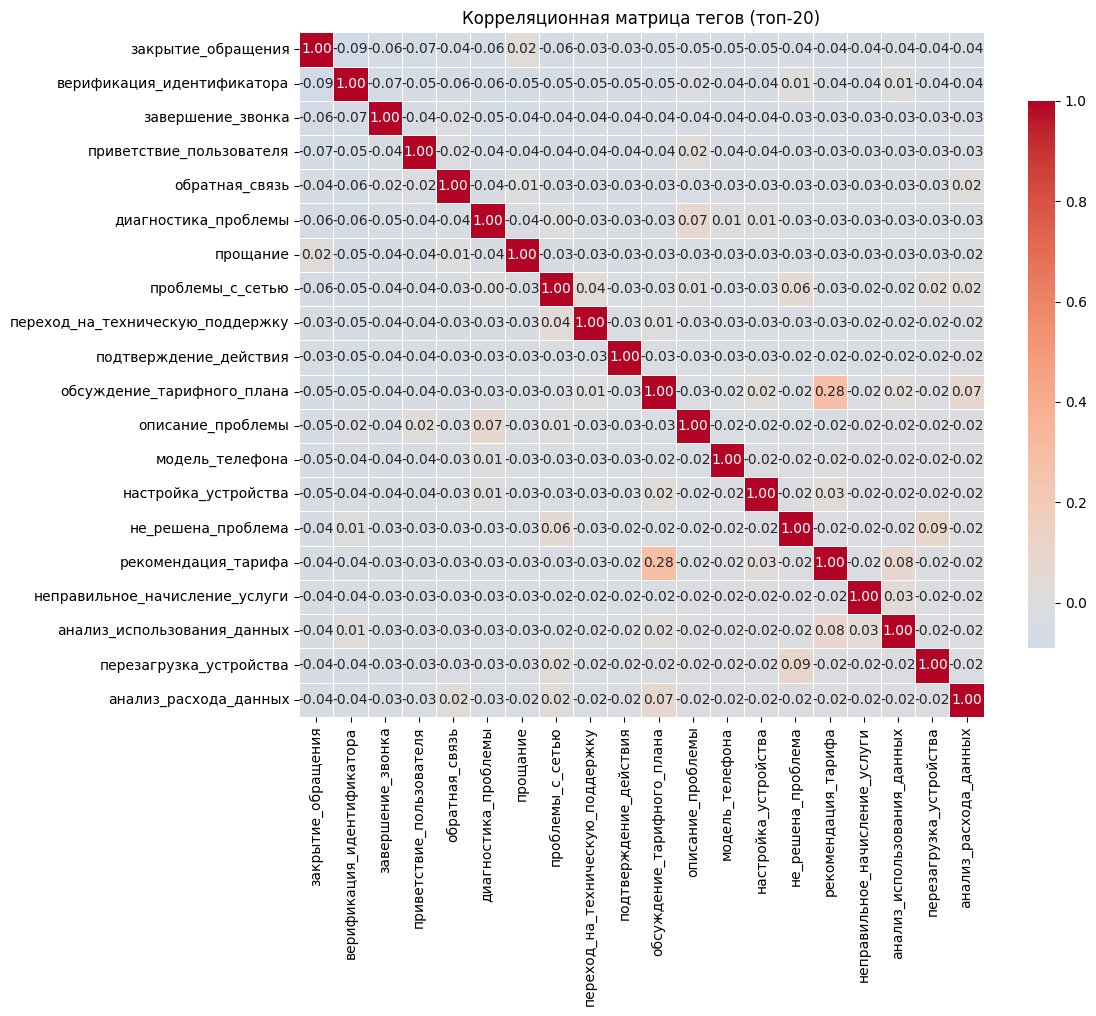

✓ Визуализация создана!


In [37]:
# Визуализация корреляционной матрицы (если установлен matplotlib/seaborn)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Берем топ-20 тегов для визуализации
    top_tags = analysis['statistics'].head(20)['tag'].tolist()
    corr_subset = analysis['correlation'].loc[top_tags, top_tags]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Корреляционная матрица тегов (топ-20)')
    plt.tight_layout()
    plt.show()
    
    print("✓ Визуализация создана!")
except ImportError:
    print("Для визуализации установите matplotlib и seaborn: pip install matplotlib seaborn")
except Exception as e:
    print(f"Ошибка при создании визуализации: {e}")


## Резюме

Функции успешно протестированы:
- ✅ `expand_tags_to_columns()` - создает столбцы tag_[name] для каждого тега
- ✅ `analyze_tags()` - собирает статистику и корреляционный анализ
